In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from math import cos, pi, ceil
from abc import abstractmethod, ABC

In [2]:
MAX_ITERS = 10000

In [3]:
def norm(A: np.ndarray, B: np.ndarray):
    assert A.shape == B.shape, "Матрицы должны быть одинакового размера"
    diff = A - B
    return np.sqrt(np.sum(diff ** 2))

In [4]:
class ElipticEquation(ABC):
    @abstractmethod
    def Phi_1(self, y: float):
        pass

    @abstractmethod
    def Phi_2(self, y: float):
        pass
    
    @abstractmethod
    def Phi_3(self, x: float):
        pass
    
    @abstractmethod
    def Phi_4(self, x: float):
        pass

    @abstractmethod
    def U(self, x: float, y: float):
        pass

    @abstractmethod
    def f(self, x, y):
        pass

    @property
    @abstractmethod
    def l1(self):
        pass

    @property
    @abstractmethod
    def l2(self):
        pass

    @property
    @abstractmethod
    def a(self):
        pass

    @property
    @abstractmethod
    def b(self):
        pass

    @property
    @abstractmethod
    def c(self):
        pass

In [5]:
class ElipticEquationVariant7(ElipticEquation):
    def Phi_1(self, y: float):
        return cos(y)

    def Phi_2(self, y: float):
        return 0 * y

    def Phi_3(self, x: float):
        return cos(x)

    def Phi_4(self, x: float):
        return 0 * x

    def U(self, x: float, y: float):
        return cos(x) * cos(y)

    def f(self, x, y):
        return 0 * x * y

    @property
    def l1(self):
        return pi / 2

    @property
    def l2(self):
        return pi / 2

    @property
    def a(self):
        return 0
    
    @property
    def b(self):
        return 0
    
    @property
    def c(self):
        return 2

In [6]:
class Solver(ABC):

    @property
    @abstractmethod
    def equation(self) -> ElipticEquation:
        pass

    @abstractmethod
    def solve(self):
        pass

In [7]:
def get_ranges(equation: ElipticEquation, delta: float):
    Nx = ceil(equation.l1 / delta)
    Ny = ceil(equation.l2 / delta)
    hx = equation.l1 / (Nx - 1)
    hy = equation.l2 / (Ny - 1)
    xrange=(0, equation.l1 + hx)
    yrange=(0, equation.l2 + hy)
    x = np.arange(*xrange, hx)
    y = np.arange(*yrange, hy)
    return x, y, hx, hy

In [8]:
class AnalyticSolverVariant7(Solver):
    def __init__(self, equation: ElipticEquation, delta: float = 0.05) -> None:
        self._equation = equation
        self._delta = delta
    
    @property
    def equation(self) -> ElipticEquation:
        return self._equation
    
    def solve(self):
        x, y, _, _ = get_ranges(self.equation, self._delta)
        u = np.zeros((len(x), len(y)))
        for i in range(len(x)):
            for j in range(len(y)):
                u[i][j] = self.equation.U(x[i], y[j])
        return u

In [9]:
class ApproximationMethod(ABC):
    @property
    @abstractmethod
    def hy(self):
        return self.hy
    
    @property
    @abstractmethod
    def hx(self):
        return self.hy

    @abstractmethod
    def update(self, u: np.ndarray, u_prev: np.ndarray, i: int, j: int):
        pass

    def __str__(self) -> str:
        return "Approximation method"

In [10]:
class IterationsMethodVariant7(ApproximationMethod):
    def __init__(self, hx, hy) -> None:
        self._hx = hx
        self._hy = hy
    
    @property
    def hx(self):
        return self._hx
    
    @property
    def hy(self):
        return self._hy

    def update(self, u: np.ndarray, u_prev: np.ndarray, i: int, j: int):
        _num = ((-1/self.hx**2) * (u_prev[i + 1][j] + u_prev[i - 1][j]) +
                            (-1/self.hy**2) * (u_prev[i][j + 1] + u_prev[i][j - 1]))
        _div = 2 - 2 / self.hx**2 - 2 / self.hy**2
        return _num / _div
    
    def __str__(self) -> str:
        return "Iterations method var. 7"

In [11]:
class SeidelMethodVariant7(ApproximationMethod):
    def __init__(self, hx, hy) -> None:
        self._hx = hx
        self._hy = hy
    
    @property
    def hx(self):
        return self._hx
    
    @property
    def hy(self):
        return self._hy
    
    def update(self, u: np.ndarray, u_prev: np.ndarray, i: int, j: int):
        _num = ((-1/self.hx**2) * (u_prev[i + 1][j] + u[i - 1][j]) +
                            (-1/self.hy**2) * (u_prev[i][j + 1] + u[i][j - 1]))
        _div = 2 - 2 / self.hx**2 - 2 / self.hy**2
        return _num / _div
    
    def __str__(self) -> str:
        return "Seidel method var. 7"

In [12]:
class RelaxationMethodVariant7(ApproximationMethod):
    def __init__(self, hx, hy, theta: float = 1.0) -> None:
        self._hx = hx
        self._hy = hy
        self._theta = theta
    
    @property
    def hx(self):
        return self._hx
    
    @property
    def hy(self):
        return self._hy
    
    def update(self, u: np.ndarray, u_prev: np.ndarray, i: int, j: int):
        _num = ((-1/self.hx**2) * (u_prev[i + 1][j] + u[i - 1][j]) +
                            (-1/self.hy**2) * (u_prev[i][j + 1] + u[i][j - 1]))
        _div = 2 - 2 / self.hx**2 - 2 / self.hy**2
        return self._theta * (_num / _div) + (1 - self._theta) * u_prev[i][j]
    
    def __str__(self) -> str:
        return "Relaxation method var. 7"

In [13]:
class NumericSolverVariant7(Solver):
    def __init__(self, equation: ElipticEquation, method: ApproximationMethod,
                 delta: float = 0.05, epsilon: float = 1e-3) -> None:
        self._equation = equation
        self._method = method
        self._delta = delta
        self._epsilon = epsilon
        self.x, self.y, self.hx, self.hy = get_ranges(self.equation, self._delta)
        self.n, self.m = len(self.x), len(self.y)

    @property
    def equation(self) -> ElipticEquation:
        return self._equation

    def _interpolate(self, u: np.ndarray):
        if u[0, 1:-1].any() and u[1:-1, 0].any():
            for i in range(1, self.n):
                for j in range(1, self.m):
                    u[i, j] = np.linspace(u[0, j], u[i, -1], i + 1 + (self.m - j) - 1)[i]
    
    def _init(self):
        u = np.zeros((self.n, self.m))

        for i in range(self.m):
            u[0][i] = self.equation.Phi_1(self.y[i])
            u[-1][i] = self.equation.Phi_2(self.y[i])
        for j in range(self.n):
            u[j][0] = self.equation.Phi_3(self.x[j])
            u[j][-1] = self.equation.Phi_4(self.x[j])

        return u

    def solve(self):
        u = self._init()
        self._interpolate(u)
        
        count_iterations = 1
        while True:
            u_prev = u
            u = self._init()

            x0, xn = 1, self.n - 1
            y0, yn = 1, self.m - 1
            
            for i in range(y0, yn):
                for j in range(x0, xn):
                    u[i][j] = self._method.update(u, u_prev, i, j)

            if norm(u, u_prev) < self._epsilon:
                break

            count_iterations += 1
            if count_iterations > MAX_ITERS:
                raise StopIteration()

        print(f"Solving with {str(self._method)}, count_iterations = {count_iterations}")

        return u

Solving with Iterations method var. 7, count_iterations = 541
Solving with Seidel method var. 7, count_iterations = 353
Solving with Relaxation method var. 7, count_iterations = 158
Серия графиков u(x, y=y_fix) и u(y, x=x_fix):


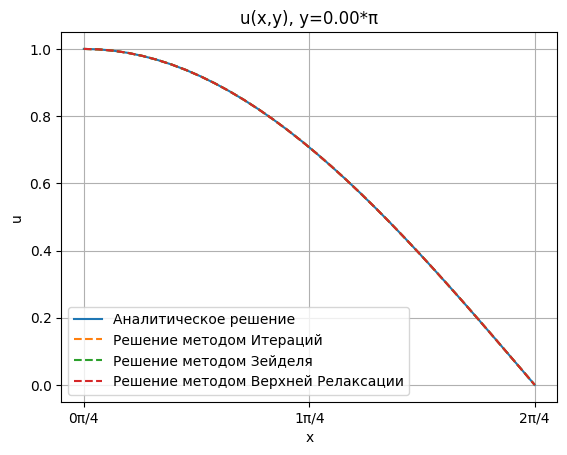

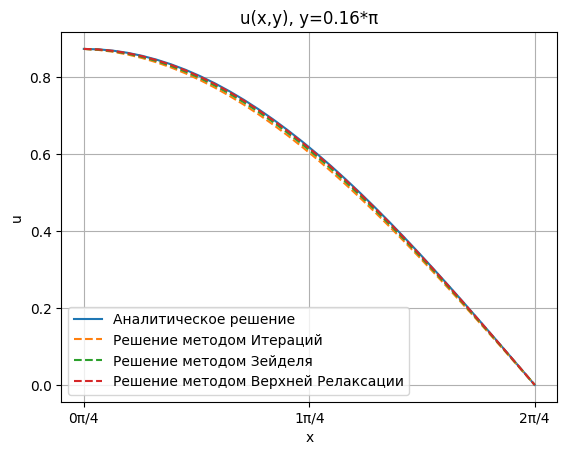

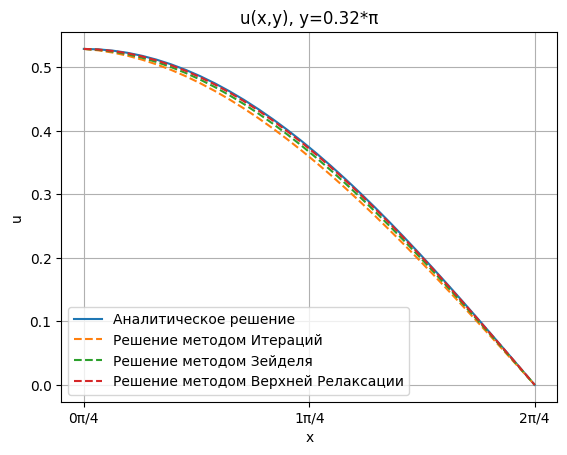

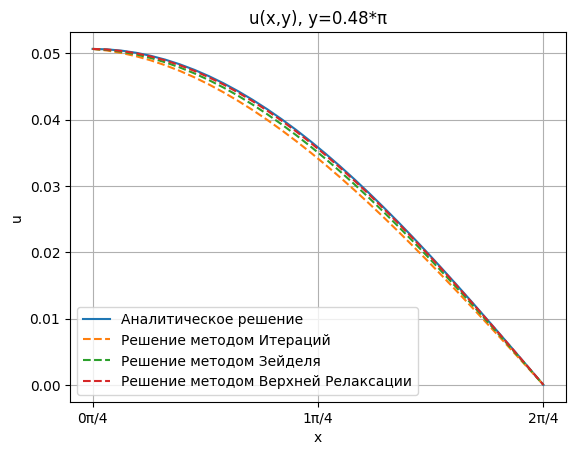

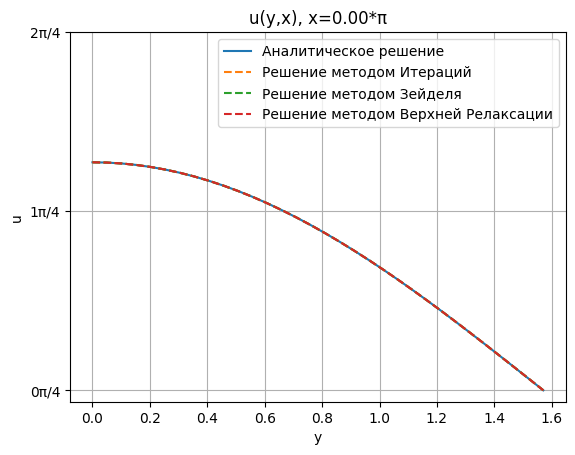

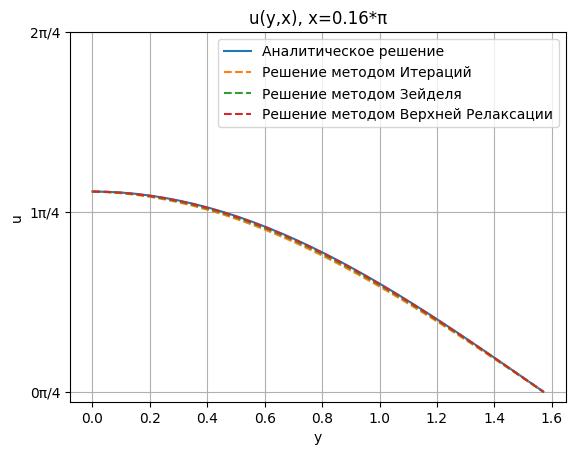

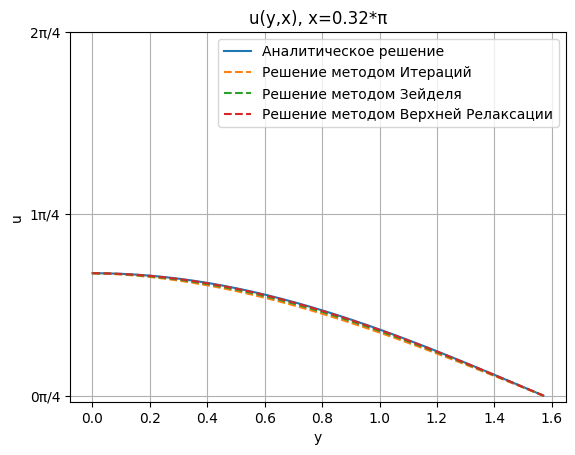

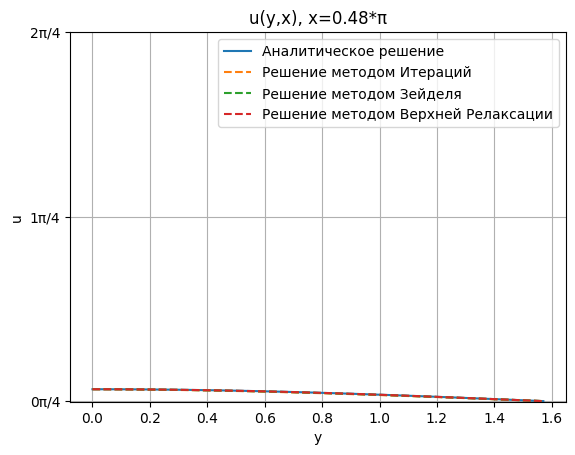

In [14]:
eq = ElipticEquationVariant7()
delta = 0.05
epsilon = 1e-3
theta=1.5
x, y, hx, hy = get_ranges(eq, delta=delta)
iteration_method = IterationsMethodVariant7(hx, hy)
seidel_method = SeidelMethodVariant7(hx, hy)
relaxation_method = RelaxationMethodVariant7(hx, hy, theta)
annalytic_solver = AnalyticSolverVariant7(eq, delta=delta)
iteration_solver = NumericSolverVariant7(eq, method=iteration_method, delta=delta, epsilon=epsilon)
seidel_solver = NumericSolverVariant7(eq, method=seidel_method, delta=delta, epsilon=epsilon)
relaxation_solver = NumericSolverVariant7(eq, method=relaxation_method, delta=delta, epsilon=epsilon)
u_analytic = annalytic_solver.solve()
u_iteration = iteration_solver.solve()
u_seidel = seidel_solver.solve()
u_relaxation = relaxation_solver.solve()

# Допустим, хотим построить несколько графиков u(x, y=y_fix)
# при разных значениях y с заданным шагом. Например, шаг 0.5.
# Функция для преобразования координат в кратные π
def format_pi_ticks(ax, axis='x'): 
    if axis == 'x':
        ax.set_xticks(np.arange(0, eq.l1 + pi / 4, pi / 4))
        ax.set_xticklabels([f"{i}π/4" for i in range(len(ax.get_xticks()))])
    elif axis == 'y':
        ax.set_yticks(np.arange(0, eq.l2 + pi / 4, pi / 4))
        ax.set_yticklabels([f"{i}π/4" for i in range(len(ax.get_yticks()))])

print("Серия графиков u(x, y=y_fix) и u(y, x=x_fix):")
y_step = 0.5
y_values = np.arange(0, eq.l2, y_step)

for y_val in y_values:
    j = np.argmin(np.abs(y - y_val))
    plt.figure()
    plt.plot(x, u_analytic[:, j], label="Аналитическое решение")
    plt.plot(x, u_iteration[:, j], linestyle='--', label="Решение методом Итераций")
    plt.plot(x, u_seidel[:, j], linestyle='--', label="Решение методом Зейделя")
    plt.plot(x, u_relaxation[:, j], linestyle='--', label="Решение методом Верхней Релаксации")
    plt.title(f"u(x,y), y={(y[j] / pi):.2f}*π")
    plt.xlabel("x")
    plt.ylabel("u")
    ax = plt.gca()
    format_pi_ticks(ax, axis='x')
    plt.legend()
    plt.grid(True)
    plt.show()

x_step = 0.5
x_values = np.arange(0, eq.l1, x_step)

for x_val in x_values:
    i = np.argmin(np.abs(x - x_val))
    plt.figure()
    plt.plot(y, u_analytic[i, :], label="Аналитическое решение")
    plt.plot(y, u_iteration[i, :], linestyle='--', label="Решение методом Итераций")
    plt.plot(y, u_seidel[i, :], linestyle='--', label="Решение методом Зейделя")
    plt.plot(y, u_relaxation[i, :], linestyle='--', label="Решение методом Верхней Релаксации")
    plt.title(f"u(y,x), x={(x[i] / pi):.2f}*π")
    plt.xlabel("y")
    plt.ylabel("u")
    ax = plt.gca()
    format_pi_ticks(ax, axis='y')
    plt.legend()
    plt.grid(True)
    plt.show()


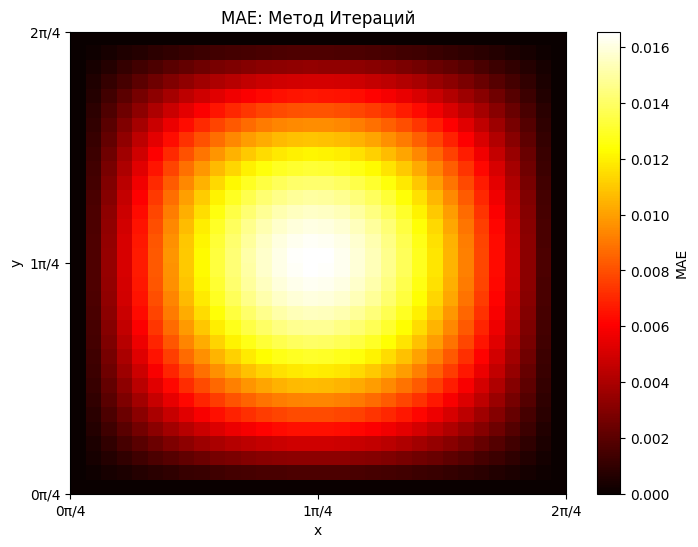

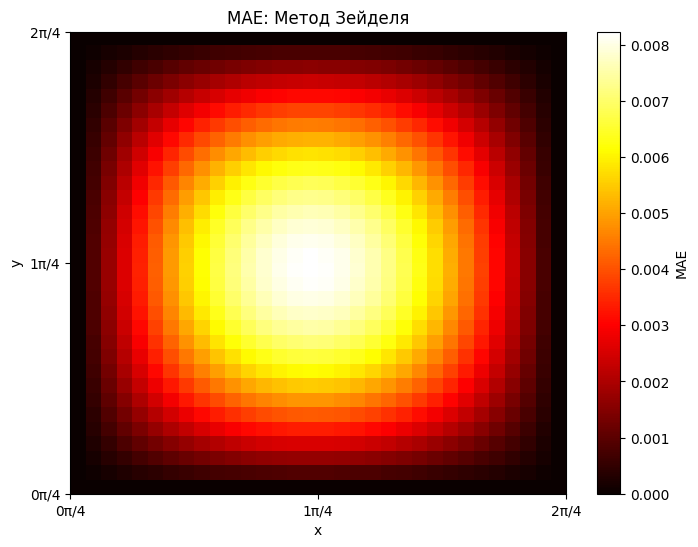

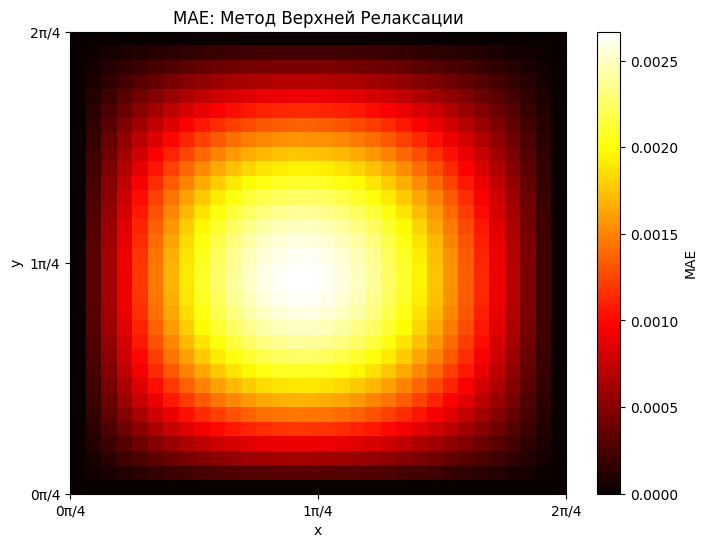

In [15]:
mae_iteration = np.abs(u_analytic - u_iteration)
mae_seidel = np.abs(u_analytic - u_seidel)
mae_relaxation = np.abs(u_analytic - u_relaxation)

# Функция для отображения тепловой карты MAE
def plot_mae_heatmap(mae, title, x, y):
    plt.figure(figsize=(8, 6))
    plt.imshow(mae.T, extent=(x[0], x[-1], y[0], y[-1]), origin='lower', aspect='auto', cmap='hot')
    plt.colorbar(label='MAE')
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    ax = plt.gca()
    format_pi_ticks(ax, axis='x')
    format_pi_ticks(ax, axis='y')
    plt.grid(False)
    plt.show()

plot_mae_heatmap(mae_iteration, "MAE: Метод Итераций", x, y)
plot_mae_heatmap(mae_seidel, "MAE: Метод Зейделя", x, y)
plot_mae_heatmap(mae_relaxation, "MAE: Метод Верхней Релаксации", x, y)